In [ ]:
# для jupyter
!pip install -r requirements.txt

## Подгрузка файлов для проверки (**ОБЯЗАТЕЛЬНО ЗАПУСТИТЕ**):

    1) Веса модели с лучшим качеством
    2) Предобработанные тестовые данные и обучающие (если надо)
    3) csv файлы, нужны для датасетов

In [41]:
import gdown

# веса
weights_id = '1-8NzgkRcuG653oPPnHEtpRuJmMXh02IZ'
url_w = f'https://drive.google.com/uc?id={weights_id}'
gdown.download(url_w, 'best_model_weights.pth')

# тестовая выборка
test_id = '1-22r4uFsw1pkL9wAVKZZrlQUt8z8v56t'
test_last_part_id = '1wpkBWLGvjFLgiX1-MAie9YwoQGT3XKit'
url_test = f'https://drive.google.com/uc?id={test_id}'
url_test_last_part = f'https://drive.google.com/uc?id={test_last_part_id}'
gdown.download(url_test, 'test_first_part.npy')
gdown.download(url_test_last_part, 'test_last_part.npy')

# обучающая выборка (раскомментируйте, но там 700 мб)
# train_id = '1OHrahleQaITa5FAhpZeaf-JEPLzkEtwz'
# url_train = f'https://drive.google.com/uc?id={train_id}'
# gdown.download(url_train, 'train.npy')

# csv файлы
train_csv_id = '1zz3-r4TIj6dVV00bwy6rnD9SlHFEVlCA'
test_csv_id = '1BEbyby93t0LvGO1HlkFl5so9jLoWoD8y'
url_train_csv = f'https://drive.google.com/uc?id={train_csv_id}'
url_test_csv = f'https://drive.google.com/uc?id={test_csv_id}'
gdown.download(url_train_csv, 'train.csv')
gdown.download(url_test_csv, 'test.csv')

# загрузка сабмита с кагла (это я для себя проверил)
sub_id = '1HdF0CfqPBFWuaNM4obpTnHEgADgk0XV1'
url_sub = f'https://drive.google.com/uc?id={sub_id}'
gdown.download(url_sub, 'sub_kaggle.csv')

Downloading...
From: https://drive.google.com/uc?id=1-8NzgkRcuG653oPPnHEtpRuJmMXh02IZ
To: /content/best_model_weights.pth
100%|██████████| 2.60M/2.60M [00:00<00:00, 39.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-22r4uFsw1pkL9wAVKZZrlQUt8z8v56t
From (redirected): https://drive.google.com/uc?id=1-22r4uFsw1pkL9wAVKZZrlQUt8z8v56t&confirm=t&uuid=919a0555-9ce8-483e-a331-bdd8d77495b7
To: /content/test_first_part.npy
100%|██████████| 120M/120M [00:01<00:00, 62.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wpkBWLGvjFLgiX1-MAie9YwoQGT3XKit
To: /content/test_last_part.npy
100%|██████████| 2.45M/2.45M [00:00<00:00, 64.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zz3-r4TIj6dVV00bwy6rnD9SlHFEVlCA
To: /content/train.csv
100%|██████████| 838k/838k [00:00<00:00, 16.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BEbyby93t0LvGO1HlkFl5so9jLoWoD8y
To: /content/test.csv
100%|██████████| 60.0k/60.0k [00:00<00:00, 3.74MB/s]
Downloading...
F

'sub_kaggle.csv'

**Перед просмотром кода, прочитайте**

Общая концепция описана в ридми, но по ходу скроллинга ноутбука будут пометки почему я делал так, а не иначе, а также попробовал сам найти минусы в решении (надеюсь, меня это не закопает). Для проверки, что я не жулик, в конце последовательно все модули для быстрого теста.

## Загрузка общих библиотек, которые я использовал.

Я по привычке не загружал все библиотеки в одной ячейке, **но для проверки теста внизу отдельно собарана выжимка, чтобы не бегать по ноутбуку.**

In [10]:
import librosa
import os

# для рисования
import matplotlib.pyplot as plt
import seaborn as sns

# для подсчета расстояния Левенштейна
import nltk

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from tqdm.auto import tqdm


train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

alphabet = ['_', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', '#']

# это для декода
le = LabelEncoder().fit(alphabet)

## opus to numpy (предобработка). Тут нужны все файлы opus, чтобы повторить, поэтому это просто демонстрация, она не нужна для повтора (ну внутри полезный текст описания)

А вот как по мне и корень всех моих бед, в самом начале, но я уже не уверен ни в чем. Мне кажется, что предобаботка могла быть лучше.

Сначала конвертируем опус файлы в мелспектрограммы. При этом шаг по времени 64, потому что так мне показалось на глаз лучше видно штрихи и точки.

Посмотрев данные, я увидел, что у нас весь сигнал на одной частоте (но это не всегда могло быть так), но я решил брать частоту с максимальной средней амплитудой и +- 3 герц, потому что иногда все же данные дублировались в ближайших частотах + min_max нормализация, чтобы все значения были от 0 до 1. Как итог: массивы размером [6, 1001].

Думаю, что можно было сделать лучше, но я не смог грамотно убрать амплитудный шум на используемой частоте (размытие точек на тесте например).

Все это дело я сохранил, потому что каждый раз в цикле обучения проделывать такое очень долго.

In [ ]:
def opus_to_np(path):
    y, sr = librosa.load(path, sr=8000)
    hop_length = 64
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, hop_length=hop_length)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

def mm_norm(arr):
    return (arr - np.min(arr))/(np.max(arr) - np.min(arr))

In [ ]:
S_dB_sclices = []
for i in tqdm(range(train_df.shape[0])):
    # получаем саму мел-спектрограмму
    file_name, _ = train_df.loc[i]
    file_path = os.path.join(data_path, file_name)
    mel = opus_to_np(file_path)

    # обрезаем все вокруг сигнала
    mel_slice = mel.copy()
    morse_line = np.argmax(mel_slice.mean(axis=1))
    line = mel_slice[morse_line - 3: morse_line + 3, :]
    S_dB_sclices.append(mm_norm(line))

S_dB_sclices = np.stack(S_dB_sclices)
np.save('/content/drive/MyDrive/conture/morse_data/morse_dataset/mels_sliced_64hop.npy', S_dB_sclices)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [ ]:
S_dB_sclices = []
for i in tqdm(range(test_df.shape[0])):
    # получаем саму мел-спектрограмму
    file_name = test_df['id'][i]
    file_path = os.path.join(data_path, file_name)
    mel = opus_to_np(file_path)

    # обрезаем все вокруг сигнала
    mel_slice = mel.copy()
    morse_line = np.argmax(mel_slice.mean(axis=1))
    line = mel_slice[morse_line - 3: morse_line + 3, :]
    S_dB_sclices.append(mm_norm(line))

S_dB_sclices_main = np.stack(S_dB_sclices[:-17])
S_dB_sclices_last_part = np.stack(S_dB_sclices[-17:])
np.save('/content/drive/MyDrive/conture/morse_data/morse_dataset/test_mels_sliced_64hop.npy', S_dB_sclices_main)
np.save('/content/drive/MyDrive/conture/morse_data/morse_dataset/test_last_part_mels_sliced_64hop.npy', S_dB_sclices_last_part)

## Датасет

Тут все просто. Единственное, нужно было поменять collate на другую функцию, потому что обычный stack из даталоадера мне не даст нормально загружать таргеты в ctc loss

In [12]:
from torch.utils.data import DataLoader, Dataset
from torch import from_numpy
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import random_split
from torch.optim import Adam


class MorseDataset(Dataset):
    def __init__(self, mels, df, encoder, test=False):
        self.mels = mels
        self.df = df
        self.encoder = encoder
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        if self.test:
            return from_numpy(self.mels[idx])
        _, label = self.df.loc[idx]
        encoded_label = self.encoder.transform([i for i in label])
        return from_numpy(self.mels[idx]), encoded_label

# тк разные длины у таргета, то stack внутри DataLoader не подходит
def collate(batch):
    inputs, targets = zip(*batch)

    inputs = torch.stack(inputs)

    flat_targets = torch.tensor(np.concatenate(targets), dtype=torch.long)
    target_lengths = torch.tensor([len(seq) for seq in targets], dtype=torch.long)

    return inputs, flat_targets, target_lengths

Это если нужно будет обучение повторить (но идеально оно не повторится, так как я не фиксировал seed на торче для даталодеров, поэтому перемешивание рандомное)

In [11]:
mels = np.load('train.npy')

In [13]:
full_dataset = MorseDataset(mels, train_df, le)

# Тут я у меня 3 даталоадера - train/val для прогонов, а full - для отправки,
# потому что сначала нужно было динамику модели посмотреть и отлавливать переобучение

# Сид зафиксировал, чтобы воиспрозводить выборку, если будет нужно.
# Этого недостаточно, чтобы полностью повторить обучение (потому что в cuda свои ньюансы),
# но так я сравнивал разные варианты модели
gen = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_dataset, [0.95, 0.05], generator=gen)

train_dataloader = DataLoader(train_dataset,
                              batch_size= 64,
                              shuffle=True,
                              num_workers=0,
                              collate_fn=collate)
val_dataloader = DataLoader(val_dataset,
                            batch_size= 64,
                            shuffle=False,
                            num_workers=0,
                            collate_fn=collate)

full_dataloader = DataLoader(full_dataset,
                             batch_size= 64,
                             shuffle=True,
                             num_workers=0,
                             collate_fn=collate)


# в итоге размерность инпута - 64, 6, 1001
# таргеты схлопнуты в 1d тензор + собираем длины, потому что ctc loss требует длины входов

## Модельки

А вот тут уже что-то интересное. Я нашел бейзлайн через свертки и рекурентные слои, и в целом норм идея, но сама реализация была странной, потому что данные были очень чистые в примере.

**Далее логика построения кастома (напомню, вход модели [6, 1001]):**

Основная идея в том, чтобы сжать данные до приемлемого размера (~100-200) до входа в rnn, потому что я не пользуюсь здесь вниманием (attention), да и ctc loss на такой разнице в длине таргета и истинных значениях хорош, как я прочитал.

Сначала я перевел все дело из 2d в 1d. Возможно, стоило это делать не в один слой, но мне понравилась концепция.

Первой ошибкой было делать просто сжатие свертками, а не maxpool (вместо этого, я сжимал свертками) и даже не ставить никакие нормализации батчей и дропауты, потому что задача выглядит с точки зрения выделения фичей простой. Однако потом, в ласт версии, я их добавил, потому что ошибался.

В целом такая логика везде прослеживается. Сжимаем и передаем в rnn, но это не очень хорошие результаты дает (~0.55 на тесте) и переобучается.

Четвертый вариант (V4) включает в себя батч нормы после первой свертки и после последней экстракции. Теперь первый conv_pool слой я заменил на обычный пулинг, потому что размеры точек и тире позволяют такое сделать почти не потеряв данных. Плюс добавились свертки, которые не меняют размерности, по сути делают экстракцию и переразмер по количеству каналов. + Добавил дропаут в rnn, чтобы оно не так быстро переобучалось.

**В конце этого раздела еще одна пометка.**

In [ ]:
# ТО, С ЧЕГО Я НАЧАЛ. да, 1 rnn слой...
import torch.nn.functional as F
import torch.nn as nn

class MorseDecoder(nn.Module):
    def __init__(self, alphabet_len=45):
        super(MorseDecoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=6, stride=1)
        self.conv_pool1 = nn.Conv1d(64, 128, kernel_size=5, stride=3, padding=2)
        self.conv_pool2 = nn.Conv1d(128, 128, kernel_size=5, stride=3, padding=2)
        self.rnn = nn.GRU(128, 256, num_layers=1, batch_first=True, bidirectional=True)
        self.cls = nn.Linear(512, alphabet_len)

    def forward(self, x):
        # добавляем каналы -> N, 1, 6, 1001
        x = x.unsqueeze(1)
        # свертка на всю высоту
        x = F.relu(self.conv1(x))
        # удаляем размерность высоты, потому что схлопнули до 1
        x = x.squeeze(dim=(1, 2))
        # теперь сжимаем все это дело
        x = F.relu(self.conv_pool1(x))
        x = F.relu(self.conv_pool2(x))
        # подали в rnn
        x = x.permute(0, 2, 1) # N, 64, 1, L - > N, L, 64
        x, _ = self.rnn(x)
        x = self.cls(x)
        preds = F.log_softmax(x, -1)
        return preds

model = MorseDecoder()
total_params = sum(p.numel() for p in model.parameters())
print(f"Общее количество параметров: {total_params}")

In [ ]:
class MorseDecoderV3(nn.Module):
    def __init__(self, alphabet_len=45):
        super(MorseDecoderV3, self).__init__()
        self.conv_pool1 = nn.Conv1d(1, 64, kernel_size=5, stride=3, padding=2)
        self.conv_extr = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=1)
        self.conv_pool2 = nn.Conv1d(128, 128, kernel_size=3, stride=2, padding=1)
        self.rnn = nn.GRU(128, 128, num_layers=2, batch_first=True, bidirectional=True)
        self.cls = nn.Linear(256, alphabet_len)

    def forward(self, x):
        # сжатие -> экстракция -> сжатие
        x = F.relu(self.conv_pool1(x))
        x = F.relu(self.conv_extr(x))
        x = F.relu(self.conv_pool2(x))
        # подали в rnn
        x = x.permute(0, 2, 1) # N, 64, 1, L - > N, L, 64
        x, _ = self.rnn(x)
        x = self.cls(x)
        preds = F.log_softmax(x, -1)
        return preds

model = MorseDecoderV3()

total_params = sum(p.numel() for p in model.parameters())
print(f"Общее количество параметров: {total_params}")

Когда я все это заполнял, я увидел, что батчнорм поставлен перед активацией...ошибка

In [14]:
# МОДЕЛЬ С НАИЛУЧШИМ РЕЗУЛЬТАТОМ

import torch.nn.functional as F
import torch.nn as nn


class MorseDecoderV4(nn.Module):
    def __init__(self, alphabet_len=45):
        super(MorseDecoderV4, self).__init__()
        self.conv_extr0 = nn.Conv2d(1, 64, kernel_size=6, stride=1)
        self.bn0 = nn.BatchNorm1d(64)
        self.pool0 = nn.MaxPool1d(3)
        self.conv_extr = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=1)
        self.conv_pool2 = nn.Conv1d(128, 128, kernel_size=3, stride=2, padding=1)
        self.conv_extr2 = nn.Conv1d(128, 128, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.rnn = nn.GRU(128, 128, num_layers=2, batch_first=True, bidirectional=True, dropout=0.1)
        self.cls = nn.Linear(256, alphabet_len)

    def forward(self, x):
        x = x.unsqueeze(1)
        # экстракция -> удаление оси + норма -> сжатие -> экстракция -> сжатие -> экстракция + норма
        x = self.conv_extr0(x)
        x = x.squeeze(dim=2)
        x = self.pool0(F.relu(self.bn0(x)))
        x = F.relu(self.conv_extr(x))
        x = F.relu(self.conv_pool2(x))
        x = F.relu(self.bn2(self.conv_extr2(x)))
        # подали в rnn
        x = x.permute(0, 2, 1) # N, 64, 1, L - > N, L, 64
        x, _ = self.rnn(x)
        x = self.cls(x)
        preds = F.log_softmax(x, -1)
        return preds

model = MorseDecoderV4()

total_params = sum(p.numel() for p in model.parameters())
print(f"Общее количество параметров: {total_params}")

Общее количество параметров: 648557


In [15]:
model


MorseDecoderV4(
  (conv_extr0): Conv2d(1, 64, kernel_size=(6, 6), stride=(1, 1))
  (bn0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool0): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv_extr): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv_pool2): Conv1d(128, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv_extr2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): GRU(128, 128, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (cls): Linear(in_features=256, out_features=45, bias=True)
)

Как можно заметить, я обошел стороной трансформеры и внимание. Этому есть объяснение.

Обучать трансформер долго и колаб не даст мне использовать гпу столько времени, но это ладно, можно и на датасферу яндекса занести пару тысяч за пару часов на A100. Основной причиной является сложность задачи. Мне кажется, что использовать на такой задаче такие тяжелые методы - это стрелять с танка по комару (даже с учетом, что это соревнование, я поверил, что и без этого смогу в топ забраться). Возможно, стоило добавить внимание (да даже многоголовое), но мне показалось, что тут не нужно "помнить" rnn, что было в начале, потому что текст неосмысленный, да и буквы относительно короткие, хотя это могло бы в теори убрать шумы.

## Обучение

### utils

В этой ячейке просто написаны декодировщики выходов модели в буквы, они похожие все на задачах с ctc loss. Убираем бланки и повторы.

In [ ]:
# декодировка предсказаний
def decoder(logits, encoder, blank_index=0): # я не знаю, зачем я бланк отдельно занес в параметры
    blank_index = encoder.transform(['_']).item()
    predicted_indices = torch.argmax(logits, dim=-1)

    decoded_strings = []
    for b in range(predicted_indices.size(1)):
        indices = predicted_indices[:, b].cpu().detach().numpy()
        decoded = []
        prev_idx = -1
        for idx in indices:
            if idx != blank_index and (prev_idx != idx):
                decoded.append(encoder.inverse_transform([idx]).item())
            prev_idx = idx

        decoded_strings.append(''.join(decoded))

    return decoded_strings

# декодировка таргетов (это, чтобы посмотреть расстояние Левенштейна)
def decode_targets(targets, target_lengths, label_encoder):
    targets = targets.cpu().detach().numpy()
    target_lengths = target_lengths.cpu().detach().numpy()

    decoded_strings = []
    start_idx = 0
    for length in target_lengths:
        target = targets[start_idx:start_idx+length]
        start_idx += length
        decoded = label_encoder.inverse_transform(target)
        decoded_strings.append(''.join(decoded))

    return decoded_strings

Отдельный класс просто для удобства. Тут есть и ранняя остановка обучения и сохранение модели, все можно настроить. Мне такая конструкция нравится, хотя в ней есть свои небольшие минусы (часто много параметров и надо конфиги отдельно делать, но в этом задании я решил их не прописывать). Тут и мониторинг качества на эпохе и лосс, чтобы остановки делать.

ЕСТЬ МИНУС. Я не использовал шедулер, потому что в первый раз с ctc loss работал и не понимал, какая у него динамика (все в пропусках на первых эпохах было открытием), поэтому далее да, я руками останавливал, писал с какой эпохи начинать и менял lr, смотря, как у меня меняется динамика обучения. Такое здесь, мне кажется, можно делать, потому что модель тратит 1 минуту на эпоху и в итоге тонкая настрока занимает где-то минут 30, а шедулер выбирать мне показалось, как пальцем в небо тыкать.

Но в итоге, достаточно работать с 1 ячейкой и все само перезапускается с любыми параметрами, классно же.

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, func_loss, n_epochs, device, encoder, model_safe=None):
        self.model = model
        self.optimizer = optimizer
        self.func_loss = func_loss
        self.device = device
        self.n_epochs = n_epochs
        self.encoder = encoder
        self.model_safe = model_safe

    def train(self, train_loader, val_loader=None, schedule=None, start_epoch=0, save_step=5):
        self.model.to(self.device)
        train_loss = []
        val_loss = []
        train_distance = []
        val_distance = []

        for epoch in range(start_epoch, self.n_epochs + start_epoch):
            self.model.train()
            epoch_train_loss = 0
            epoch_distance = 0

            for batch in tqdm(train_loader, desc=f'Epoch: {epoch + 1}'):
                mel_specs, targets, tar_lens = batch
                mel_specs = mel_specs.to(self.device)
                targets = targets.to(self.device)
                tar_lens = tar_lens.to(self.device)

                self.optimizer.zero_grad()

                preds = self.model(mel_specs)

                perm_preds = preds.permute(1, 0, 2) # N, L, C -> L, N, C
                pred_lens = torch.full(size=(perm_preds.size(1),),
                                           fill_value=perm_preds.size(0),
                                           dtype=torch.long,
                                           device=self.device)
                # после всех переразмеров можем и loss посчитать
                loss = self.func_loss(perm_preds, targets, pred_lens, tar_lens)
                loss.backward()

                self.optimizer.step()

                # декодируем наше чудо
                decoded_preds = decoder(perm_preds, self.encoder) # получаем список строк предсказаний
                decoded_targets = decode_targets(targets, tar_lens, self.encoder) # получаем список строк таргетов
                epoch_distance += nltk.edit_distance(decoded_preds, decoded_targets) # считаем расстояние
                # тут кншн ошибка, что я буду брать для эпохи среднее по средним для loss, но мб это стоило исправить
                epoch_train_loss += loss.item()


            # считаем среднее расстояние на эпохе и средний от среднего лосс
            train_distance.append(epoch_distance / len(train_loader.dataset)) # тут делим на длину датасета, тк считаем отдельно для каждого примера
            train_loss.append(epoch_train_loss / len(train_loader))

            if val_loader is not None:
                epoch_val_loss, epoch_val_distance = self.evaluate(val_loader)
                val_loss.append(epoch_val_loss)
                val_distance.append(epoch_val_distance)

                # выводим наши метрики
                print(f"Training Loss: {train_loss[-1]:.4f}, "
                    f"Training Dist: {train_distance[-1]:.6f}, "
                    f"Val loss: {val_loss[-1]:.4f}, "
                    f"Val Dist: {val_distance[-1]:.6f}")
            else:
                # выводим наши метрики без валидации, если ее нет
                print(f"Training Loss: {train_loss[-1]:.4f}, "
                    f"Training Dist: {train_distance[-1]:.6f}")

            # сохраняем модельку
            if (epoch + 1) % save_step == 0:
                torch.save(self.model.state_dict(), os.path.join(self.model_safe, f'model_epoch_{epoch + 1}.pth'))

        return train_loss, val_loss, train_distance, val_distance

    def evaluate(self, val_loader):
        self.model.eval()
        loss = 0
        distance = 0
        for batch in tqdm(val_loader):
            mel_specs, targets, tar_lens = batch
            mel_specs = mel_specs.to(self.device)
            targets = targets.to(self.device)
            tar_lens = tar_lens.to(self.device)

            with torch.no_grad():
                preds = self.model(mel_specs)

                perm_preds = preds.permute(1, 0, 2) # N, L, C -> L, N, C
                pred_lens = torch.full(size=(perm_preds.size(1),),
                                            fill_value=perm_preds.size(0),
                                            dtype=torch.long,
                                            device=self.device)
                loss += self.func_loss(perm_preds, targets, pred_lens, tar_lens).item()

            decoded_preds = decoder(perm_preds, self.encoder)
            decoded_targets = decode_targets(targets, tar_lens, self.encoder)
            distance += nltk.edit_distance(decoded_preds, decoded_targets)

        return loss/len(val_loader), distance/len(val_loader.dataset)

### обучение всего на свете

Сначала я прогонял с валидацией, чтобы примерно понять, где я получаю переобучение.

Вот по эпохам, какой был lr:

    V4
    1) 1-15: 2e-3;
    2) 16-20: 5e-4;
    3) 21-25: 5e-6;

Ну я прописал все, чтобы можно было все воспроизвести (вот создание папки)

In [5]:
!mkdir save_train_val_model

In [ ]:
# прогон сохраненной (или нет) модели с train/val

model = MorseDecoderV4()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_epoch = 0 # если снова обучать, то с 0
save_model_path = 'save_train_val_model'
if start_epoch != 0:
    model.load_state_dict(torch.load(os.path.join(save_model_path, f'model_epoch_{start_epoch}.pth'), map_location=device))

blank_label = le.transform(['_']).item()
ctc_loss = nn.CTCLoss(blank=blank_label)
optimizer = Adam(model.parameters(), lr=5e-6)
n_epochs = 30

trainer = Trainer(model,
                  optimizer=optimizer,
                  func_loss=ctc_loss,
                  n_epochs=n_epochs,
                  device=device, encoder=le,
                  model_safe=save_model_path)

train_loss, val_loss, train_distance, val_distance = trainer.train(train_loader=train_dataloader,
                                                                   val_loader=val_dataloader, start_epoch=start_epoch)

Epoch: 21:   0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Training Loss: 0.0776, Training Dist: 0.137088, Val loss: 0.1367, Val Dist: 0.190667


Epoch: 22:   0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Training Loss: 0.0776, Training Dist: 0.137439, Val loss: 0.1371, Val Dist: 0.190000


Epoch: 23:   0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Training Loss: 0.0769, Training Dist: 0.135930, Val loss: 0.1369, Val Dist: 0.192000


Epoch: 24:   0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Training Loss: 0.0762, Training Dist: 0.136035, Val loss: 0.1369, Val Dist: 0.194667


Epoch: 25:   0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Training Loss: 0.0763, Training Dist: 0.134561, Val loss: 0.1368, Val Dist: 0.192667


Epoch: 26:   0%|          | 0/446 [00:00<?, ?it/s]

KeyboardInterrupt: 

Да, тут немного другие параметры, а переобучение я уже смотрел просто отправками на кагл. Но иначе я не придумал, только так я могу все данные пронать и посмотреть, где у меня надо остановку делать.

lr на полном датасете:

    V4 full dataset:
    1-10: 2e-3;
    11-15: 1e-4;
    16-20: 1e-6

In [ ]:
!mkdir save_full_model

In [ ]:
# прогон сохраненной (или нет) модели с full_dataset

model = MorseDecoderV4()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_epoch = 0 # если с снова обучать, то с 0
save_model_path = 'save_full_model'
if start_epoch != 0:
    model.load_state_dict(torch.load(os.path.join(save_model_path, f'model_epoch_{start_epoch}.pth'), map_location=device))

blank_label = le.transform(['_']).item()
ctc_loss = nn.CTCLoss(blank=blank_label)
optimizer = Adam(model.parameters(), lr=1e-6)
n_epochs = 30

trainer = Trainer(model,
                  optimizer=optimizer,
                  func_loss=ctc_loss,
                  n_epochs=n_epochs,
                  device=device, encoder=le,
                  model_safe=save_model_path)

train_loss, val_loss, train_distance, val_distance = trainer.train(train_loader=full_dataloader, start_epoch=start_epoch)

Epoch: 16:   0%|          | 0/469 [00:00<?, ?it/s]

Training Loss: 0.0778, Training Dist: 0.135967


Epoch: 17:   0%|          | 0/469 [00:00<?, ?it/s]

Training Loss: 0.0772, Training Dist: 0.133600


Epoch: 18:   0%|          | 0/469 [00:00<?, ?it/s]

Training Loss: 0.0771, Training Dist: 0.133700


Epoch: 19:   0%|          | 0/469 [00:00<?, ?it/s]

Training Loss: 0.0776, Training Dist: 0.136300


Epoch: 20:   0%|          | 0/469 [00:00<?, ?it/s]

Training Loss: 0.0773, Training Dist: 0.136100


Epoch: 21:   0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Тест и отправка

Тут просто загрузка данных, но последние 17 в отдельном файле, так как они имеют другую размерность. Позже я их порезал, на пару ячеек ниже.

In [ ]:
mels_test = np.load('test_first_part.npy')
mels_test_last = np.load('test_last_part.npy')

In [ ]:
# сначала разберемся с первой частью, потом с ласт 17
test_dataset = MorseDataset(mels_test, test_df[:-17], le, test=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size= 64,
                             shuffle=False,
                             num_workers=0)

In [ ]:
# первая часть тестового датасета
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MorseDecoderV4()
model.load_state_dict(torch.load('best_model_weights.pth', map_location=device))

blank_label = le.transform(['_']).item()
model.to(device)
decoded_test = []

model.eval()
for batch in tqdm(test_dataloader):
    mel_specs = batch
    mel_specs = mel_specs.to(device)

    with torch.no_grad():
        preds = model(mel_specs)

        perm_preds = preds.permute(1, 0, 2) # N, L, C -> L, N, C

        decoded_preds = decoder(perm_preds, le)
        decoded_test += decoded_preds

  0%|          | 0/78 [00:00<?, ?it/s]

### Наивное разделение более длинных сигналов

Как и сказано, втупую порежем на нужную длину и склеим, но на итоговой отправке я так не делал

In [ ]:
# втупую поделим западим и посмотрим на результат
def split_arrays_with_padding(arrays, chunk_size=1001, pad_value=0):
    chunks = []
    for arr in arrays:
        padded_arr = np.pad(arr, ((0, 0), (5, 0)), mode='constant', constant_values=0)
        for i in range(0, padded_arr.shape[1], chunk_size):
            chunk = padded_arr[:, i:i+chunk_size]
            chunks.append(from_numpy(chunk))
    return chunks

chunks = split_arrays_with_padding(mels_test_last)

In [ ]:
decoded_test_last = []

model.eval()
for i in range(6, len(chunks) + 6, 6):
    mel_specs = torch.stack(chunks[i - 6: i])
    mel_specs = mel_specs.to(device)

    with torch.no_grad():
        preds = model(mel_specs)

        perm_preds = preds.permute(1, 0, 2) # N, L, C -> L, N, C

        decoded_preds = decoder(perm_preds, le)
        decoded_test_last.append(decoded_preds)

last_seqs = []
for list_seq in decoded_test_last:
    res_seq = ''.join(list_seq)
    last_seqs.append(res_seq)

In [ ]:
last_seqs

['ДАМИНАМТ ДОТИ РСНМСАУЦИИЕЕЕЕ',
 'ИЛ ЬСВЕДТКЧВНТИЯМДМЫМЮНЯМЦ ЮТИЫМ ЬТКИЧМЫН ДТЫНФЦЗ ЕПИГГЕЕ',
 'АНХ ВСОЕГЬ Р ВГЕДАМИ НКШМДНИ ГЕКНЖТААЕЕЕ',
 'ИЛ ДАСДП ЬСОЕМУНТИ АГВКСОЕП ЬКСХЫСУС ХНУ ЮН ХЕИУСИИЕЕ',
 'ЕТЬТКП ДСЯНКМЫНАЦ ИМККЕЕЕЕ',
 'КНОЬКМ СОЕНЫМОП ЬСЮНВММЕЕЕЕ',
 'ИЛ ЬСОЕНДМЫМ ЙТВНУС ЙЫМЧАТУС ЬКЕДЛХТ ЫМЖАЛШ ДЛУНЕВ  М ЧТЫНАМБЕЕ',
 'ИЛ ДАСДП ОСЮПИЫМ НЮЙГРГ ЕТЫТЕАКНЩННЕЕЕ',
 'АС АТ ИСЧТИ КГЖНЕПОЦ ЮН НЙГТСЫЗЕАПЗ ДТКАГИЕПЙМИДСЫДДЕЕ',
 'ТОЫМ ДЛ ОЫАИХМЕТ #ЕС ЬСОЦЕНАМТ ЕС ЕЕРЫМРАТАЕТОПЕЕ',
 'АН ЖНОЕСЕТ ЬТКЕВНЖМ ГДТЫМЖТААСЕ5 АН 75 РМЫСЯГРЫСДДЕЕ',
 'ОДЦЮП ЬСВВТКТГМДНТЕОЦ ДКГЖАГЗАТГЕСИМИЛИМ ЬНЫПНИМ АНХМШ СЬТКНЕСКСДЕЕ',
 'ОРСКС ИЛ ДАСДПЬСОЕМУАТИ ЕНБАЛ КДРТЕАЛШ ВДМУНЕТЦЕББЕЕ',
 'ОИСЧТИ СЕЬКНДЕЕФ ЮН ДНИМ  ОЬНОМЕТЫПАЛБ ЖТЫАСРЕЕЕ',
 'ТОЫМ ДЛ ЬСЕПТЫНТЕТ ДТКАГЕПЕВЦ ВСИСБ ННЕЕЕ',
 'ОДТЕ ОСЫАЯАИНКМЕ ЧМЮАП РНГИЮСИГЕЕЕ',
 'РХАТЯ ЬТКТВНЖМЕЕЕЕЕ']

### Ручная разметка по пробелам

Вроде, никто не запрещал делать ручную разметку теста, ну только последние 17 примеров, понятно. Я их разбил по пробелам (иногда пропускал пробелы, если позволяла длина), а потом падил по последней размерности до 1001 с двух сторон. В целом, это мне не помогло сдать эти примеры правильно)))

<Axes: >

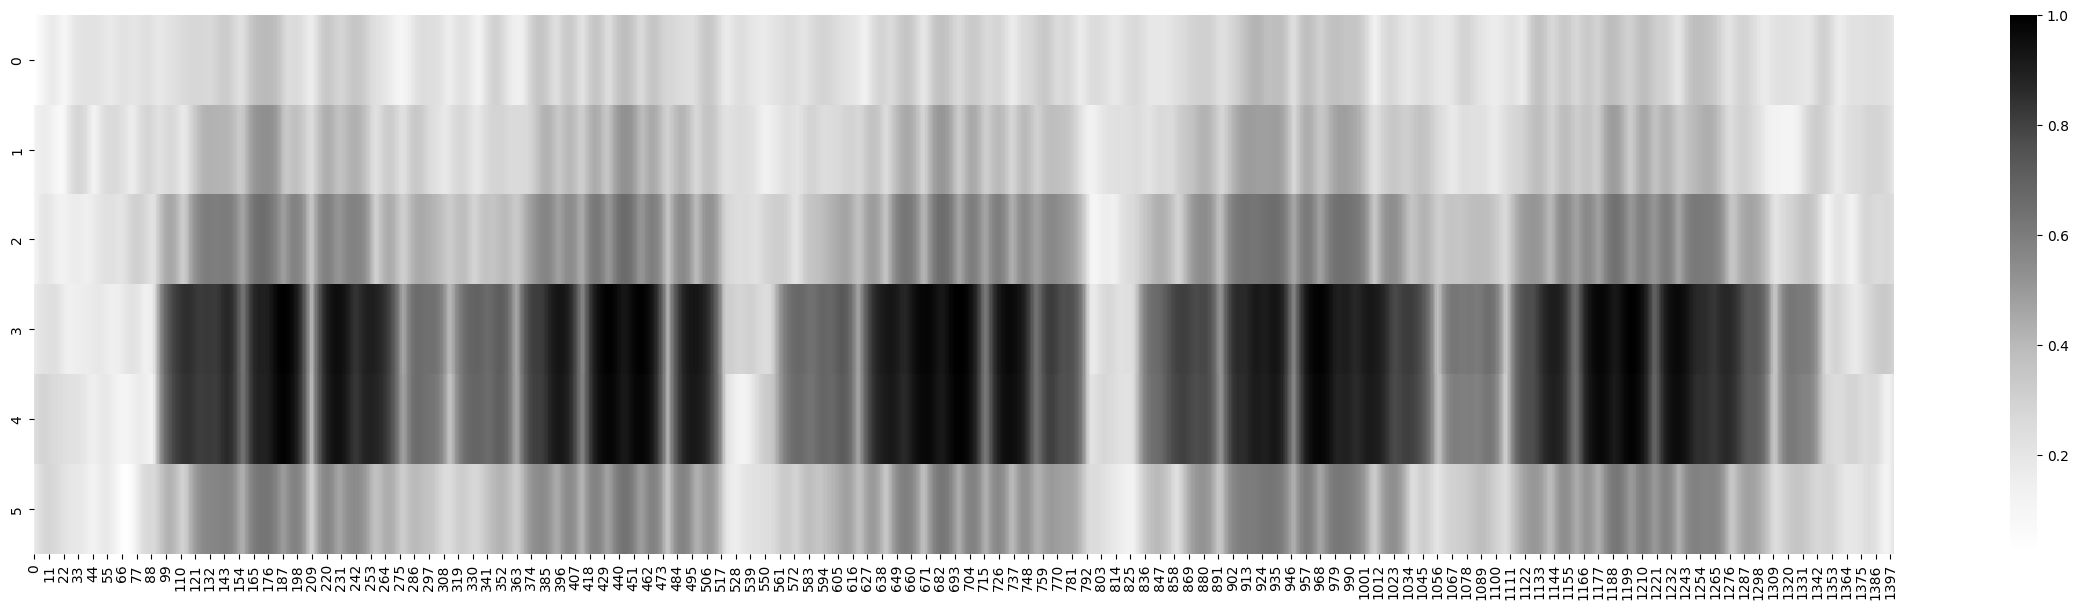

In [ ]:
# просто пример первого послания из 17, зря я что ль импорт делаю matplotlib и seaborn?
test_mel = mels_test_last[0][:, :1400]
plt.figure(figsize=(30, 7))
sns.heatmap(test_mel, cmap='Greys')

In [ ]:
gates = {
    0: [0, 528, 803, 1400],
    1: [0, 270, 998, 1809, 2160, 2727, 3240, 3500],
    2: [0, 252, 792, 1242, 1746, 2196],
    3: [0, 550, 1150, 1790, 2450, 3200],
    4: [0, 407, 1397],
    5: [0, 507, 1090, 1534],
    6: [0, 860, 1815, 2755, 3712],
    7: [0, 630, 1220, 1750, 2356],
    8: [0, 780, 1710, 2595, 3180, 3900],
    9: [0, 676, 1300, 2300, 2444, 3380],
    10: [0, 702, 1290, 2080, 2480, 3328],
    11: [0, 558, 1470, 1984, 2530, 3100, 4030],
    12: [0, 1000, 1875, 2450, 3150],
    13: [0, 535, 1071, 1470, 2290, 2700],
    14: [0, 770, 1452, 2200, 2750],
    15: [0, 912, 1748, 2300],
    16: [0, 1001],
}
def gate_split_with_pad(arrays, gates, chunk_size=1001, pad_value=0):
    all_chunks = []
    for i, gate in gates.items():
        chunks = []
        for idx in range(1, len(gate)):
            new_array = arrays[i, :, gate[idx-1]:gate[idx]]
            delta = chunk_size - new_array.shape[1]
            new_array = np.pad(new_array, ((0, 0), (delta//2, delta - delta//2)), mode='constant', constant_values=0)
            chunks.append(from_numpy(new_array))
        all_chunks.append(chunks)
    return all_chunks

In [ ]:
padded_mels = gate_split_with_pad(mels_test_last, gates)

In [ ]:
decoded_test_last = []

model.eval()
for mel in padded_mels:
    mel_specs = torch.stack(mel)
    mel_specs = mel_specs.to(device)

    with torch.no_grad():
        preds = model(mel_specs)

        perm_preds = preds.permute(1, 0, 2) # N, L, C -> L, N, C

        decoded_preds = decoder(perm_preds, le)
        decoded_test_last.append(decoded_preds)

last_seqs = []
for list_seq in decoded_test_last:
    res_seq = ' '.join(list_seq)
    last_seqs.append(res_seq)

Неприятно, что я написла скрипт для смены точек на тире и тд, но не учел, что 1 ошибка даст мне и далее кучу ошбок, поэтому мой ужас выдал мне что-то на ровне: TTEEETTETETE. Но да, мне помогло, что много раз ИЛ встречается. (вообще я зачем-то во всякие шифры Цезаря полез и тд, но это было не основное задание, так что я просто развлекался).

In [ ]:
last_seqs

['БАМИНАМН БОТИ РСЫСАМЦИ',
 'И5 ЬСВЕДТКЧВНТИ ЯМДМЫМЮНЯМЦ ЮТИЫМ ЬТЖТЧМЫН ДТЫМРГЗ ЕПИ5',
 'АНХ ВСОЕГЬ Р ВКТДАМИ НКШМДНИ ГКНЖТА',
 'ИЛ ДАСДП ЬСОЕМУНТИ ИГВКСОЕП ЬКСХЫСУС ХНУ ЮН ХНУСИ',
 'ЕТЬТКП ДСЯНКМЫОЦ ИМК',
 'КНОЬКМ СОЕНЫМОП ЬСЮНВМ',
 'ИЛ ЬСОЕНДМЫМ ЙЫНУС ЙЫМЧАТУС ЬКТДЛХТ ЫМЖАЛШ ДЛУСВ М ЧТЫНАМБ',
 'ИЛ ДАСДП ОСЮВНЫМ НЮЙГРГ ЕТЫТУКНЩН',
 'АС АТ ИСЧТИ КГЖНЕПОЦ ЮН НЙОСЫЗЕ9З ДТКАСОЕП ОМИДСЫСД',
 'ТОЫМ ДЛ ОЫЛХВЕТ #ЕС ЬСОЫНАМТ ЕС СЕРЫМРАМЕТОП',
 'АН ЖНОЕСЕТ ЬТКТВНЖМ ГДТЫМЖТААСБ АН 75 РМЫСЯМРЫСД',
 'ОДЦЮП ЬСВВТКЧМДНТЕОЦ ДКГЖАГЗ АТГЕСИМИЛИМ ЬНЫПЯНИМ АНХМШ СЬТКНЕСКСД',
 'ОРСКС ИЛ ДАСДП ЬСОЕМУАТИ ЕНБАЛ КНРТЕАЛШ ВДМУНЕТЫТБ',
 'ОИСЧТИ СЕЬКНДМЕП ЮН ДНИМ ОЬНОМЕТЫПАЛБ ЖТЫАСР',
 'ТОЫМ ДЛ ЬСЧТЫНТЕТ ДТКАГЕПОЦ ВСИСБ НН',
 'ОДТЕ ОСЫАЯН ВНКМЕ ЧМЮАП РНЧВСИГ',
 'РСАТЯ ЬТКТВНЖМ']

### Отправка

In [ ]:
# объединяем результаты и отправляем
results = decoded_test + last_seqs
sub_df = test_df.copy()
sub_df['message'] = results

sub_df.to_csv('sub.csv', index=False)

## Тут просто последовательно все нужные модули для отправки результатов, как сверху. Просто все последовательно запускаете и готово. (только файлы загрузите сверху...)

In [17]:
import librosa
import os

# для рисования
import matplotlib.pyplot as plt
import seaborn as sns

# для подсчета расстояния Левенштейна
import nltk

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from tqdm.auto import tqdm


train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

alphabet = ['_', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', '#']

# это для декода
le = LabelEncoder().fit(alphabet)

In [18]:
from torch.utils.data import DataLoader, Dataset
from torch import from_numpy
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import random_split
from torch.optim import Adam


class MorseDataset(Dataset):
    def __init__(self, mels, df, encoder, test=False):
        self.mels = mels
        self.df = df
        self.encoder = encoder
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        if self.test:
            return from_numpy(self.mels[idx])
        _, label = self.df.loc[idx]
        encoded_label = self.encoder.transform([i for i in label])
        return from_numpy(self.mels[idx]), encoded_label

# тк разные длины у таргета, то stack внутри DataLoader не подходит
def collate(batch):
    inputs, targets = zip(*batch)

    inputs = torch.stack(inputs)

    flat_targets = torch.tensor(np.concatenate(targets), dtype=torch.long)
    target_lengths = torch.tensor([len(seq) for seq in targets], dtype=torch.long)

    return inputs, flat_targets, target_lengths

In [19]:
import torch.nn.functional as F
import torch.nn as nn


class MorseDecoderV4(nn.Module):
    def __init__(self, alphabet_len=45):
        super(MorseDecoderV4, self).__init__()
        self.conv_extr0 = nn.Conv2d(1, 64, kernel_size=6, stride=1)
        self.bn0 = nn.BatchNorm1d(64)
        self.pool0 = nn.MaxPool1d(3)
        self.conv_extr = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=1)
        self.conv_pool2 = nn.Conv1d(128, 128, kernel_size=3, stride=2, padding=1)
        self.conv_extr2 = nn.Conv1d(128, 128, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.rnn = nn.GRU(128, 128, num_layers=2, batch_first=True, bidirectional=True, dropout=0.1)
        self.cls = nn.Linear(256, alphabet_len)

    def forward(self, x):
        x = x.unsqueeze(1)
        # экстракция -> удаление оси + норма -> сжатие -> экстракция -> сжатие -> экстракция + норма
        x = self.conv_extr0(x)
        x = x.squeeze(dim=2)
        x = self.pool0(F.relu(self.bn0(x)))
        x = F.relu(self.conv_extr(x))
        x = F.relu(self.conv_pool2(x))
        x = F.relu(self.bn2(self.conv_extr2(x)))
        # подали в rnn
        x = x.permute(0, 2, 1) # N, 64, 1, L - > N, L, 64
        x, _ = self.rnn(x)
        x = self.cls(x)
        preds = F.log_softmax(x, -1)
        return preds

In [20]:
# декодировка предсказаний
def decoder(logits, encoder, blank_index=0): # я не знаю, зачем я бланк отдельно занес в параметры
    blank_index = encoder.transform(['_']).item()
    predicted_indices = torch.argmax(logits, dim=-1)

    decoded_strings = []
    for b in range(predicted_indices.size(1)):
        indices = predicted_indices[:, b].cpu().detach().numpy()
        decoded = []
        prev_idx = -1
        for idx in indices:
            if idx != blank_index and (prev_idx != idx):
                decoded.append(encoder.inverse_transform([idx]).item())
            prev_idx = idx

        decoded_strings.append(''.join(decoded))

    return decoded_strings

# декодировка таргетов (это, чтобы посмотреть расстояние Левенштейна)
def decode_targets(targets, target_lengths, label_encoder):
    targets = targets.cpu().detach().numpy()
    target_lengths = target_lengths.cpu().detach().numpy()

    decoded_strings = []
    start_idx = 0
    for length in target_lengths:
        target = targets[start_idx:start_idx+length]
        start_idx += length
        decoded = label_encoder.inverse_transform(target)
        decoded_strings.append(''.join(decoded))

    return decoded_strings

In [21]:
class Trainer:
    def __init__(self, model, optimizer, func_loss, n_epochs, device, encoder, model_safe=None):
        self.model = model
        self.optimizer = optimizer
        self.func_loss = func_loss
        self.device = device
        self.n_epochs = n_epochs
        self.encoder = encoder
        self.model_safe = model_safe

    def train(self, train_loader, val_loader=None, schedule=None, start_epoch=0, save_step=5):
        self.model.to(self.device)
        train_loss = []
        val_loss = []
        train_distance = []
        val_distance = []

        for epoch in range(start_epoch, self.n_epochs + start_epoch):
            self.model.train()
            epoch_train_loss = 0
            epoch_distance = 0

            for batch in tqdm(train_loader, desc=f'Epoch: {epoch + 1}'):
                mel_specs, targets, tar_lens = batch
                mel_specs = mel_specs.to(self.device)
                targets = targets.to(self.device)
                tar_lens = tar_lens.to(self.device)

                self.optimizer.zero_grad()

                preds = self.model(mel_specs)

                perm_preds = preds.permute(1, 0, 2) # N, L, C -> L, N, C
                pred_lens = torch.full(size=(perm_preds.size(1),),
                                           fill_value=perm_preds.size(0),
                                           dtype=torch.long,
                                           device=self.device)
                # после всех переразмеров можем и loss посчитать
                loss = self.func_loss(perm_preds, targets, pred_lens, tar_lens)
                loss.backward()

                self.optimizer.step()

                # декодируем наше чудо
                decoded_preds = decoder(perm_preds, self.encoder) # получаем список строк предсказаний
                decoded_targets = decode_targets(targets, tar_lens, self.encoder) # получаем список строк таргетов
                epoch_distance += nltk.edit_distance(decoded_preds, decoded_targets) # считаем расстояние
                # тут кншн ошибка, что я буду брать для эпохи среднее по средним для loss, мб это стоило исправить
                epoch_train_loss += loss.item()


            # считаем среднее расстояние на эпохе и средний от среднего лосс
            train_distance.append(epoch_distance / len(train_loader.dataset)) # тут делим на длину датасета, тк считаем отдельно для каждого примера
            train_loss.append(epoch_train_loss / len(train_loader))

            if val_loader is not None:
                epoch_val_loss, epoch_val_distance = self.evaluate(val_loader)
                val_loss.append(epoch_val_loss)
                val_distance.append(epoch_val_distance)

                # выводим наши метрики
                print(f"Training Loss: {train_loss[-1]:.4f}, "
                    f"Training Dist: {train_distance[-1]:.6f}, "
                    f"Val loss: {val_loss[-1]:.4f}, "
                    f"Val Dist: {val_distance[-1]:.6f}")
            else:
                # выводим наши метрики без валидации, если ее нет
                print(f"Training Loss: {train_loss[-1]:.4f}, "
                    f"Training Dist: {train_distance[-1]:.6f}")

            # сохраняем модельку
            if (epoch + 1) % save_step == 0:
                torch.save(self.model.state_dict(), os.path.join(self.model_safe, f'model_epoch_{epoch + 1}.pth'))

        return train_loss, val_loss, train_distance, val_distance

    def evaluate(self, val_loader):
        self.model.eval()
        loss = 0
        distance = 0
        for batch in tqdm(val_loader):
            mel_specs, targets, tar_lens = batch
            mel_specs = mel_specs.to(self.device)
            targets = targets.to(self.device)
            tar_lens = tar_lens.to(self.device)

            with torch.no_grad():
                preds = self.model(mel_specs)

                perm_preds = preds.permute(1, 0, 2) # N, L, C -> L, N, C
                pred_lens = torch.full(size=(perm_preds.size(1),),
                                            fill_value=perm_preds.size(0),
                                            dtype=torch.long,
                                            device=self.device)
                loss += self.func_loss(perm_preds, targets, pred_lens, tar_lens).item()

            decoded_preds = decoder(perm_preds, self.encoder)
            decoded_targets = decode_targets(targets, tar_lens, self.encoder)
            distance += nltk.edit_distance(decoded_preds, decoded_targets)

        return loss/len(val_loader), distance/len(val_loader.dataset)

In [22]:
gates = {
    0: [0, 528, 803, 1400],
    1: [0, 270, 998, 1809, 2160, 2727, 3240, 3500],
    2: [0, 252, 792, 1242, 1746, 2196],
    3: [0, 550, 1150, 1790, 2450, 3200],
    4: [0, 407, 1397],
    5: [0, 507, 1090, 1534],
    6: [0, 860, 1815, 2755, 3712],
    7: [0, 630, 1220, 1750, 2356],
    8: [0, 780, 1710, 2595, 3180, 3900],
    9: [0, 676, 1300, 2300, 2444, 3380],
    10: [0, 702, 1290, 2080, 2480, 3328],
    11: [0, 558, 1470, 1984, 2530, 3100, 4030],
    12: [0, 1000, 1875, 2450, 3150],
    13: [0, 535, 1071, 1470, 2290, 2700],
    14: [0, 770, 1452, 2200, 2750],
    15: [0, 912, 1748, 2300],
    16: [0, 1001],
}
def gate_split_with_pad(arrays, gates, chunk_size=1001, pad_value=0):
    all_chunks = []
    for i, gate in gates.items():
        chunks = []
        for idx in range(1, len(gate)):
            new_array = arrays[i, :, gate[idx-1]:gate[idx]]
            delta = chunk_size - new_array.shape[1]
            new_array = np.pad(new_array, ((0, 0), (delta//2, delta - delta//2)), mode='constant', constant_values=0)
            chunks.append(from_numpy(new_array))
        all_chunks.append(chunks)
    return all_chunks

In [23]:
mels_test = np.load('test_first_part.npy')
mels_test_last = np.load('test_last_part.npy')

In [24]:
# сначала разберемся с первой частью, потом с ласт 17
test_dataset = MorseDataset(mels_test, test_df[:-17], le, test=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size= 64,
                             shuffle=False,
                             num_workers=0)

In [26]:
# первая часть тестового датасета
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MorseDecoderV4()
model.load_state_dict(torch.load('best_model_weights.pth', map_location=device))

blank_label = le.transform(['_']).item()
model.to(device)
decoded_test = []

model.eval()
for batch in tqdm(test_dataloader):
    mel_specs = batch
    mel_specs = mel_specs.to(device)

    with torch.no_grad():
        preds = model(mel_specs)

        perm_preds = preds.permute(1, 0, 2) # N, L, C -> L, N, C

        decoded_preds = decoder(perm_preds, le)
        decoded_test += decoded_preds

  0%|          | 0/78 [00:00<?, ?it/s]

In [27]:
# вторая часть
padded_mels = gate_split_with_pad(mels_test_last, gates)
decoded_test_last = []

model.eval()
for mel in padded_mels:
    mel_specs = torch.stack(mel)
    mel_specs = mel_specs.to(device)

    with torch.no_grad():
        preds = model(mel_specs)

        perm_preds = preds.permute(1, 0, 2) # N, L, C -> L, N, C

        decoded_preds = decoder(perm_preds, le)
        decoded_test_last.append(decoded_preds)

last_seqs = []
for list_seq in decoded_test_last:
    res_seq = ' '.join(list_seq)
    last_seqs.append(res_seq)

In [28]:
# объединяем результаты и отправляем
results = decoded_test + last_seqs
sub_df = test_df.copy()
sub_df['message'] = results

sub_df.to_csv('sub.csv', index=False)

In [35]:
# я проверил, что у вас совпадет для себя (повторил эксперимент)

sub_kaggle = pd.read_csv('sub_kaggle.csv')
if (sub_df == sub_kaggle)['message'].sum().item() == 5000:
    print('УРА Я НИКОГО НЕ ОБМАНУЛ')

УРА Я НИКОГО НЕ ОБМАНУЛ
